### *Perguntas:*

  1) De acordo com o tempo de resposta, qual a respectiva área queimada (área ardida) equivalente?
  
  2) Qual a causa com maior incidência de incêndios de acordo com o período do ano?

### Importando as Bibliotecas:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime
import math
#import io
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale = 1.2, rc={"lines.linewidth": 2})

### Importando o Dataset:

Importando o arquivo:

In [60]:
#from google.colab import files
#uploaded = files.upload()

Saving Lista Incendios_2015.xlsx to Lista Incendios_2015 (1).xlsx


In [61]:
df = pd.read_excel("Lista Incendios_2015.xlsx") 

Selecionando somente as variáveis que serão trabalhadas neste projeto:

In [62]:
df = df[['Tipo', 'Concelho', 'DataAlerta', 'HoraAlerta', 'TipoCausa','AA_Povoamento (ha)','AA_Mato (ha)','AA_Agricola (ha)','AA_EspacosFlorestais (pov+mato)(ha)', 'AA_Total (pov+mato+agric) (ha)', 'Data1Intervencao', 'Hora1Intervencao']]

### Análises Preliminares

In [63]:
df.sample(5)

,Tipo,Concelho,DataAlerta,HoraAlerta,TipoCausa,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Data1Intervencao,Hora1Intervencao
10607,Florestal,Montalegre,2015-03-10 00:00:00.000,20:00:00,Negligente,0.000,2.0,0.00,2.000,2.000,2015-03-10 00:00:00.000,20:15:00
5953,Florestal,Ponte de Sor,2015-05-10 00:00:00.000,13:05:00,Negligente,0.285,0.0,0.00,0.285,0.285,NaN,NaN
2320,Florestal,Sabugal,2015-02-25 00:00:00.000,13:29:00,Negligente,1.570,1.0,1.00,2.570,3.570,2015-02-25 00:00:00.000,14:03:00
4590,Agrícola,Póvoa de Lanhoso,2015-06-29 00:00:00.000,17:55:00,Desconhecida,0.000,0.0,0.68,0.000,0.680,2015-06-29 00:00:00.000,18:15:00
17659,Florestal,Celorico de Basto,2015-07-10 00:00:00.000,03:14:00,Intencional,0.000,0.3,0.00,0.300,0.300,2015-07-10 00:00:00.000,03:30:00


A coluna **DataAlerta** Apresenta o horário zerado em todas as linhas. Em seguida, será preciso acertar esses dados, colocando a hora que está na coluna **HoraAlerta**. O mesmo ocorre com a coluna **Data1Intervencao**. Estes dois acertos serão fundamentais para criar a variável **Tempo de Resposta**, sobre a qual diz respeito a primeira pergunta deste trabalho

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23175 entries, 0 to 23174
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Tipo                                 23175 non-null  object 
 1   Concelho                             23175 non-null  object 
 2   DataAlerta                           23175 non-null  object 
 3   HoraAlerta                           23175 non-null  object 
 4   TipoCausa                            16162 non-null  object 
 5   AA_Povoamento (ha)                   23175 non-null  float64
 6   AA_Mato (ha)                         23175 non-null  float64
 7   AA_Agricola (ha)                     23175 non-null  float64
 8   AA_EspacosFlorestais (pov+mato)(ha)  23175 non-null  float64
 9   AA_Total (pov+mato+agric) (ha)       23175 non-null  float64
 10  Data1Intervencao                     21976 non-null  object 
 11  Hora1Intervencao            

Por enquanto, somente as colunas relacionadas a área (**AA_Povoamento (ha)**, **AA_Mato (ha)**, **AA_Agricola (ha)**,**AA_EspacosFlorestais (pov+mato)(ha)** e **AA_Total (pov+mato+agric) (ha)**) apresentam valores numéricos.

Checando os null-values das colunas:

In [65]:
df.isnull().sum()

Tipo                                      0
Concelho                                  0
DataAlerta                                0
HoraAlerta                                0
TipoCausa                              7013
AA_Povoamento (ha)                        0
AA_Mato (ha)                              0
AA_Agricola (ha)                          0
AA_EspacosFlorestais (pov+mato)(ha)       0
AA_Total (pov+mato+agric) (ha)            0
Data1Intervencao                       1199
Hora1Intervencao                       1213
dtype: int64

As colunas **Data1Intervencao**, **Hora1Intervencao** e **TipoCausa** apresentam *null-values*. Trataremos desses casos em seguida.

####Checando se há áreas inconsistentes:

In [66]:
df.describe()

,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha)
count,23175.000000,23175.000000,23175.000000,23175.000000,23175.000000
mean,1.024671,1.756081,0.167752,2.780753,2.948505
std,19.487999,40.187748,3.089877,49.350016,50.083970
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.005000
50%,0.000000,0.005000,0.000000,0.020000,0.040000
75%,0.000000,0.100000,0.000000,0.230000,0.340000
max,1548.920000,4499.000000,224.160000,4661.000000,4673.000000


In [67]:
df[df['AA_Total (pov+mato+agric) (ha)'] == 4673.000000]

,Tipo,Concelho,DataAlerta,HoraAlerta,TipoCausa,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Data1Intervencao,Hora1Intervencao
19913,Florestal,Sabugal,2015-08-22 00:00:00.000,02:36:00,Natural,162.0,4499.0,12.0,4661.0,4673.0,2015-08-22 00:00:00.000,02:56:00


Conforme dados das páginas 3 a 7 do RELATÓRIO DE ESTABILIZAÇÃO DE EMERGÊNCIA GRANDES INCÊNDIOS FLORESTAIS NO SABUGAL de 2015 (disponível em: http://www2.icnf.pt/portal/florestas/dfci/relat/raa/resource/doc/ree2015/CENTRO-REE-SABUGAL_2015.pdf), 5163 ha foram queimados em Sabugal em decorrência de uma ocorrência recebida por volta das 02:36 do dia 22 de agosto de 2015.

Ainda, a área florestal total ardida em agosto de 2015 foi abaixo da média do mês de agosto entre os anos 2005 a 2014, assim como a área florestal total ardida em 2015 também foi abaixo da média histórica para o mesmo período (ver quadro 4 do RELATÓRIO ROVISÓRIO DE INCÊNDIOS FLORESTAIS DE 2015, disponível em http://www2.icnf.pt/portal/florestas/dfci/Resource/doc/rel/2015/9-rel-prov-1jan-30out-2015.pdf).

Este mesmo relatório diz ainda (no quadro 5 da página 8), sobre o incêndio em questão (de 22 de agosto de 2015): "O maior incêndio verificado teve início no dia 22 de agosto na freguesia de Sortelha (Sabugal), distrito da Guarda, e consumiu uma área ardida estimada de 4661 hectares de espaços florestais".

Considerando que este valor é superior mas praticamente o mesmo ao evidenciado no dataset (4673 ha), pode-se concluir que é um valor real. Logo, sabendo que este é o valor máximo da varíavel "Área Total Ardida", e ele é real, provavelmente, ao realizar-se a análise de possíveis outliers estatísticos (será feito na sequência), nenhum será um outlier irreal/incoerente.

####Análise dos quartis:

In [68]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print('Qartil 1:\n\n', Q1,'\n\nQuartil 3:\n\n', Q3,'\n\nIQR (Diferença ente quartis):\n\n', IQR)

Qartil 1:

 AA_Povoamento (ha)                     0.000
AA_Mato (ha)                           0.000
AA_Agricola (ha)                       0.000
AA_EspacosFlorestais (pov+mato)(ha)    0.000
AA_Total (pov+mato+agric) (ha)         0.005
Name: 0.25, dtype: float64 

Quartil 3:

 AA_Povoamento (ha)                     0.00
AA_Mato (ha)                           0.10
AA_Agricola (ha)                       0.00
AA_EspacosFlorestais (pov+mato)(ha)    0.23
AA_Total (pov+mato+agric) (ha)         0.34
Name: 0.75, dtype: float64 

IQR (Diferença ente quartis):

 AA_Povoamento (ha)                     0.000
AA_Mato (ha)                           0.100
AA_Agricola (ha)                       0.000
AA_EspacosFlorestais (pov+mato)(ha)    0.230
AA_Total (pov+mato+agric) (ha)         0.335
dtype: float64


Indenfiticando o máximo de um boxplot (upper whisker) da área ardida (equivalente ao quartil 3 + 1.5 * diferença entre os quartis 3 e 1):

In [69]:
Upper_Whisker = Q3 + 1.5 * IQR
print(Upper_Whisker[4])

0.8425


Indenfiticando o mínimo de um boxplot (lower whisker) da área ardida (equivalente ao quartil 3 + 1.5 * diferença entre os quartis 3 e 1):

In [70]:
Lower_Whisker = Q1 - 1.5 * IQR
print(Lower_Whisker[4])

-0.49750000000000005


Considerando que a área nunca posa ser nula, o próprio mínimo do boxplot da área ardida já seria um ponto correspondente a um valor irreal. Assim, assumiremos o upper whisker como sendo 1.235 e o lower whisker como sendo 0.

In [71]:
len(df[(df['AA_Total (pov+mato+agric) (ha)'] > Upper_Whisker[4])])

3907

Desconsiderando as instâncias correspondentes a valores vazios de Hora de Intervenção de Tipo de Causa ainda restam 2979 outliers quando avaliamos o valor da Área Total Queimada. Porém, como justificado anteriormente, provavelemnte são valores reais, e não receberão qualquer tratamento.

####Valores vazios da Área Ardida Total:

In [72]:
len(df[(df['AA_Total (pov+mato+agric) (ha)']==0)])

2925

Provavelmente esses 2925 objetos (instâncias), onde a Área Total Queimada é nula, correspondem a falsos alarmes.

####Checando o tempo de resposta

In [73]:
df[df['DataAlerta']>df['Data1Intervencao']] #df[df['TempoResposta_Minutos'] < 0]

,Tipo,Concelho,DataAlerta,HoraAlerta,TipoCausa,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Data1Intervencao,Hora1Intervencao
15253,Agrícola,Sintra,2015-07-13 00:00:00.000,04:30:00,Desconhecida,0.0,0.0,0.02,0.0,0.02,2015-07-12 00:00:00.000,16:15:00


In [74]:
print(df['DataAlerta'][[856, 4540, 4796, 10908, 15253]], '\n')
print(df['HoraAlerta'][[856, 4540, 4796, 10908, 15253]], '\n')
print(df['Data1Intervencao'][[856, 4540, 4796, 10908, 15253]], '\n')
print(df['Hora1Intervencao'][[856, 4540, 4796, 10908, 15253]])

856      2015-03-20 00:00:00.000
4540     2015-05-26 00:00:00.000
4796     2015-07-09 00:00:00.000
10908    2015-06-03 00:00:00.000
15253    2015-07-13 00:00:00.000
Name: DataAlerta, dtype: object 

856      14:00:00
4540     20:20:00
4796     15:45:00
10908    17:15:00
15253    04:30:00
Name: HoraAlerta, dtype: object 

856      2015-03-20 00:00:00.000
4540     2015-05-26 00:00:00.000
4796     2015-07-09 00:00:00.000
10908    2015-06-03 00:00:00.000
15253    2015-07-12 00:00:00.000
Name: Data1Intervencao, dtype: object 

856      13:35:00
4540     01:16:00
4796     15:40:00
10908    14:27:00
15253    16:15:00
Name: Hora1Intervencao, dtype: object


Verifica-se que há 5 instâncias onde a Data e Hora de Alerta ocorrem depois da Data e Hora de Intervenção, resultando assim em Tempos de Resposta negativos.

Por exemplo, a instância 10908 possui Data de Alerta 2015-06-03 e Hora de Alerta 17:15:00, já sua Data de Intervenção é 2015-06-03 e Hora de Intervenção 14:27:00 (ou seja, intervenção teria ocorrido antes do alerta).

Provavelmente trata-se de erros de apontamento/medida e como são poucos casos, estas instâncias serão removidas na sequência.

###Rearrumando os dados:

**df** será o *DataSet* original, enquanto que **df2** será o rearrumado

In [75]:
df2 = df

#### Removendo linhas com *null-values*

Removeremos as linhas que apresentam valores nulos nas colunas **Hora1Intervencao** e **TipoCausa**:

In [76]:
df2 = df[(df['Hora1Intervencao'].isnull() == False) & (df['TipoCausa'].isnull() == False)]

*Null-values* podem ser tratados de diversas formas, como por exemplo substituí-los pela média dos valores da coluna. Neste trabalho optamos por remover tais linhas, porque o número de linhas no *DataSet* é muito grande. Sendo assim, entendeu-se a remoção de algumas não provocará prejuízo grande a nossa análise final.

In [77]:
df2.isnull().sum()

Tipo                                   0
Concelho                               0
DataAlerta                             0
HoraAlerta                             0
TipoCausa                              0
AA_Povoamento (ha)                     0
AA_Mato (ha)                           0
AA_Agricola (ha)                       0
AA_EspacosFlorestais (pov+mato)(ha)    0
AA_Total (pov+mato+agric) (ha)         0
Data1Intervencao                       0
Hora1Intervencao                       0
dtype: int64

Agora, a tabela não apresenta *null-values*.

####Acertando as variáveis DataAlerta & Data1Intervencao

Vamos corrigir as colunas **DataAlerta** e **Data1Intervencao**, inserindo nestas colunas a hora em que os eventos ocorrem (informação contida nas colunas **Hora1Intervencao** e **HoraAlerta**).

Em seguida, removeremos as colunas **Hora1Intervencao** e **HoraAlerta**, uma vez que seus dados passarão a expressar informações já contidas nas outras colunas.

In [78]:
df2['DataAlerta']=df2['DataAlerta'].apply(lambda x:x.split('00:', 1)[0])      # Remove Horas, minutos e segundos de DataAlerta
df2['DataAlerta']=df2['DataAlerta'].astype(str)+df2['HoraAlerta'].astype(str) # Junta DataAlerta & HoraAlerta na coluna DataAlerta

df2['Data1Intervencao']=df2['Data1Intervencao'].apply(lambda x:x.split('00:', 1)[0])  # Faz o mesmo para Data1Intervencao
df2['Data1Intervencao']=df2['Data1Intervencao'].astype(str)+df2['Hora1Intervencao'].astype(str)

df2['DataAlerta'] = pd.to_datetime(df2['DataAlerta'].astype(str))
df2['Data1Intervencao'] = pd.to_datetime(df2['Data1Intervencao'].astype(str))

df2.drop(['HoraAlerta'], axis =1, inplace = True)         #Remove HoraAlerta e Hora1Intervencao do df2
df2.drop(['Hora1Intervencao'], axis =1, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [79]:
df2.head()

,Tipo,Concelho,DataAlerta,TipoCausa,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Data1Intervencao
0,Florestal,Ponte de Lima,2015-03-24 17:01:00,Negligente,2.50,0.00,0.0,2.50,2.50,2015-03-24 17:10:00
1,Florestal,Marco de Canaveses,2015-03-24 17:10:00,Negligente,0.00,1.35,0.0,1.35,1.35,2015-03-24 17:16:00
2,Florestal,Vila Verde,2015-03-24 19:15:00,Desconhecida,0.26,0.00,0.0,0.26,0.26,2015-03-24 19:25:00
3,Falso Alarme,Ponte de Lima,2015-03-24 20:05:00,Desconhecida,0.00,0.00,0.0,0.00,0.00,2015-03-24 20:20:00
4,Agrícola,Castro Daire,2015-03-24 20:10:00,Desconhecida,0.00,0.05,0.0,0.05,0.05,2015-03-24 20:15:00


#### Criando a Variável Tempo de Resposta

Esta variável é chave para respordermos a primeira pergunta do trabalho.

In [80]:
tempresp = pd.to_datetime(df2['Data1Intervencao'].astype(str)) - pd.to_datetime(df2['DataAlerta'].astype(str))
tempresp= tempresp.dt.total_seconds().astype(int)/60          # Variavel tempo de resposta em minutos
df2.insert(10,"TempoResposta_Minutos", tempresp, True)

In [81]:
df2.head()

,Tipo,Concelho,DataAlerta,TipoCausa,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Data1Intervencao,TempoResposta_Minutos
0,Florestal,Ponte de Lima,2015-03-24 17:01:00,Negligente,2.50,0.00,0.0,2.50,2.50,2015-03-24 17:10:00,9.0
1,Florestal,Marco de Canaveses,2015-03-24 17:10:00,Negligente,0.00,1.35,0.0,1.35,1.35,2015-03-24 17:16:00,6.0
2,Florestal,Vila Verde,2015-03-24 19:15:00,Desconhecida,0.26,0.00,0.0,0.26,0.26,2015-03-24 19:25:00,10.0
3,Falso Alarme,Ponte de Lima,2015-03-24 20:05:00,Desconhecida,0.00,0.00,0.0,0.00,0.00,2015-03-24 20:20:00,15.0
4,Agrícola,Castro Daire,2015-03-24 20:10:00,Desconhecida,0.00,0.05,0.0,0.05,0.05,2015-03-24 20:15:00,5.0


In [82]:
df2.describe()

,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),TempoResposta_Minutos
count,15697.000000,15697.000000,15697.000000,15697.000000,15697.000000,15697.000000
mean,1.362348,2.272069,0.235250,3.634417,3.869667,16.611263
std,23.311099,47.807347,3.735059,58.806921,59.710109,356.924953
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1144.000000
25%,0.000000,0.000000,0.000000,0.001000,0.010000,7.000000
50%,0.000000,0.010000,0.000000,0.040000,0.076500,11.000000
75%,0.001000,0.200000,0.000000,0.450000,0.500000,17.000000
max,1548.920000,4499.000000,224.160000,4661.000000,4673.000000,44645.000000


A priori, o tempo médio de resposta é de 16,61 minutos. Porém, este valor não deve estar totalmente correto, uma vez que há ao menos um tempo negativo de resposta (que é o mínimo, -1144 minutos). Precisamos, portanto, eleminar as linhas com valores negativos.

####Tratando dos Tempos de Resposta:

Como já foi mencionado na seção anterior, eliminaremos datas inconsistentes, aquelas que a data da interveção está registrada como tendo ocorrido antes do alerta.

In [83]:
df2[df2['TempoResposta_Minutos'] < 0]   # Mostra os Tempos de resposta negativos

,Tipo,Concelho,DataAlerta,TipoCausa,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Data1Intervencao,TempoResposta_Minutos
856,Florestal,Alijó,2015-03-20 14:00:00,Negligente,0.00,1.200,0.00,1.200,1.200,2015-03-20 13:35:00,-25.0
4540,Florestal,ODIVELAS,2015-05-26 20:20:00,Desconhecida,0.00,0.002,0.00,0.002,0.002,2015-05-26 01:16:00,-1144.0
4796,Agrícola,Mesão frio,2015-07-09 15:45:00,Negligente,0.00,0.000,0.04,0.000,0.040,2015-07-09 15:40:00,-5.0
10908,Florestal,Torres Vedras,2015-06-03 17:15:00,Intencional,0.01,0.220,0.00,0.230,0.230,2015-06-03 14:27:00,-168.0
15253,Agrícola,Sintra,2015-07-13 04:30:00,Desconhecida,0.00,0.000,0.02,0.000,0.020,2015-07-12 16:15:00,-735.0


Existem 5 casos em que os tempos de resposta estão negativos. Vamamos remover essas observações do nosso *DataSet*:

In [84]:
df2 = df2[df2['TempoResposta_Minutos'] > 0] # Remove  linhas com tempos de resposta negativos

Verificando:

In [85]:
df2[df2['TempoResposta_Minutos'] < 0]   # Mostra os Tempos de resposta negativos

,Tipo,Concelho,DataAlerta,TipoCausa,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),Data1Intervencao,TempoResposta_Minutos


In [86]:
df2.describe()

,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),TempoResposta_Minutos
count,15446.000000,15446.000000,15446.000000,15446.000000,15446.000000,15446.000000
mean,1.379463,2.296718,0.236809,3.676181,3.912990,17.015667
std,23.498428,48.191718,3.759039,59.279176,60.188853,359.631833
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.001000,0.010000,7.000000
50%,0.000000,0.010000,0.000000,0.040000,0.077400,11.000000
75%,0.001000,0.200000,0.000000,0.450000,0.500000,17.000000
max,1548.920000,4499.000000,224.160000,4661.000000,4673.000000,44645.000000


####Remoção de valores extremos:

A tabela anterior mostra que há ainda uma desproporção muito grande entre os dados, tanto para o tempo de resposta quanto para a área total.

Note que o terceiro quartil (75%) do tempo de resposta apresenta 17 minutos enquanto que o máximo apresenta 4673 minutos.

O mesmo ocorre com a área total: o terceiro quartil é de 0.45 ha enquanto que o valor máximo é de 4661 ha.

Estes valores podem até ser reais, mas é possível que tais desproporções dificultem muito nossa análise. Nesse sentido, guardaremos um terceiro *DataSet* (**df3**), no qual excluiremos alguns desses valores extremos.

In [87]:
df3 = df2

######Área

Se adotarmos aqui os 
critérios convencionais de indentificação de outliers: 

li = Q1 - 1.5*ΔQ

ls = Q3 +1.5*ΔQ

Com efeito:


In [88]:
Q1a = df2['AA_Total (pov+mato+agric) (ha)'].quantile(0.25) #1o quartil para a área
Q3a = df2['AA_Total (pov+mato+agric) (ha)'].quantile(0.75) #3o quartil para a área
dQa = Q3a - Q1a        # ΔQ
Lia = Q1a - 1.5*dQa   # Limite inferior para definir outliers
Lsa = Q3a + 1.5*dQa   # Limite superior para definir outliers

print('Lia=', Lia, ' & Lsa =', Lsa)

Lia= -0.725  & Lsa = 1.2349999999999999


Como o limite inferior deu negativo (e já verificamos que não há areas negativas), não é preciso se preocupar com ele. Entretanto, o limite superior é 1.23 ha, o que é muito inferior ao valor máximo original do nosso *DataSet*.

######Tempo de resposta:

In [89]:
Q1t = df2['TempoResposta_Minutos'].quantile(0.25) #1o quartil para o tempo
Q3t = df2['TempoResposta_Minutos'].quantile(0.75) #3o quartil para o tempo
dQt = Q3t - Q1t        # ΔQ
Lit = Q1t - 1.5*dQt   # Limite inferior para definir outliers
Lst = Q3t + 1.5*dQt   # Limite superior para definir outliers

print('Lit=', Lit, ' & Lst =', Lst)

Lit= -8.0  & Lst = 32.0


Novamente, o tempos negativos já foram tratados anteriormente. Entretanto, o limite superior para os tempos de resposta ainda encontram-se bem inferiores, quando comparados aos máximos.

In [90]:
df3 = df3[df3['AA_Total (pov+mato+agric) (ha)'] <= Lsa]

In [91]:
df3 = df3[df3['TempoResposta_Minutos'] <= Lst]

In [92]:
df3.describe()

,AA_Povoamento (ha),AA_Mato (ha),AA_Agricola (ha),AA_EspacosFlorestais (pov+mato)(ha),AA_Total (pov+mato+agric) (ha),TempoResposta_Minutos
count,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000
mean,0.042722,0.095149,0.028804,0.137871,0.166675,11.707767
std,0.149318,0.211715,0.118922,0.253773,0.266732,6.630506
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000100,0.010000,7.000000
50%,0.000000,0.005000,0.000000,0.020000,0.040000,11.000000
75%,0.000000,0.060000,0.000000,0.130000,0.200000,15.000000
max,1.222000,1.230000,1.210000,1.230000,1.230000,32.000000


###Plotando os gráficos

####Tipos de Causa (gráfico de barras)

Sem os *outliers*

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[]]

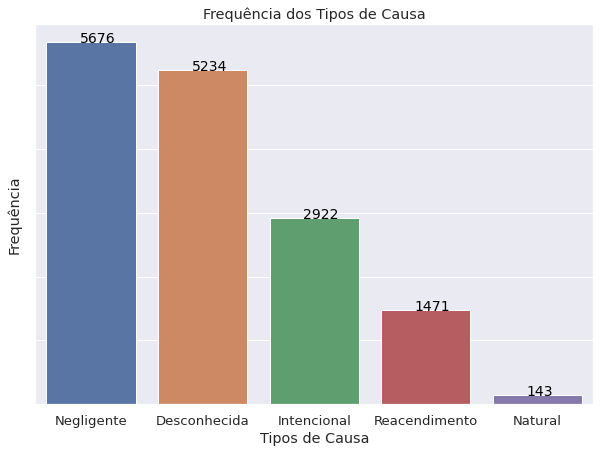

In [93]:
plt.figure(figsize=(10,7))
plt.title("Frequência dos Tipos de Causa") #
ax = sns.countplot(df2['TipoCausa'], order=df2['TipoCausa'].value_counts().index, palette='deep') 
s = df2['TipoCausa'].value_counts().head(10)
for i, v in s.reset_index().iterrows():
    ax.text(i -.1, v.TipoCausa + 0.2 , v.TipoCausa, color='black' ,fontsize= 14)
ax.set_ylabel('Frequência')
ax.set_xlabel('Tipos de Causa')
ax.set(yticklabels=[])

Com os *outliers*

Observa-se que as causas mais comuns são: negligência, desconhecida e interncional, nesta ordem. Esta última possui ocorrência muito próxima da frequência de possíveis falsos alarmes.

Perfil de Área Ardida Total para cada Tipo de Causa:

Text(0, 0.5, 'Tipos de Causa')

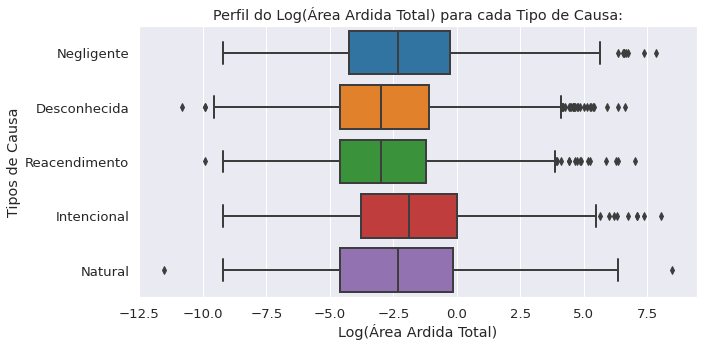

In [94]:
log_area = df2[df2['AA_Total (pov+mato+agric) (ha)']>=1e-10]['AA_Total (pov+mato+agric) (ha)']
df2['log_area'] = np.log(log_area)

plt.figure(figsize = (10,5))
sns.boxplot(x='log_area', y='TipoCausa', data=df2)
plt.title('Perfil do Log(Área Ardida Total) para cada Tipo de Causa:')
plt.xlabel('Log(Área Ardida Total)')
plt.ylabel('Tipos de Causa')

####Por Meses do Ano:

In [95]:
df2['DataAlerta'] = pd.to_datetime(df2['DataAlerta'])
df2['MesAlerta'] = df2['DataAlerta'].dt.month
df2['MesAlerta-str'] = df2['DataAlerta'].dt.strftime('%b')

Tempo de resposta:


Text(0, 0.5, 'Tempo de Resposta médio (min)')

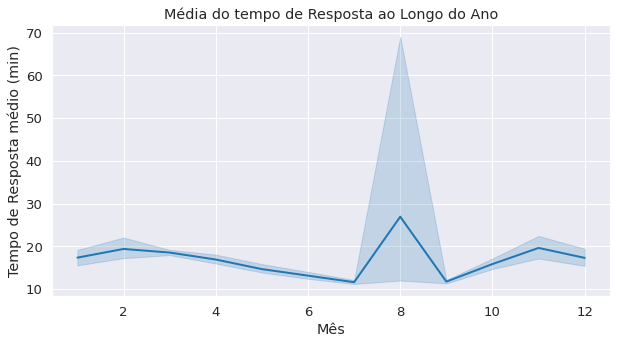

In [96]:
plt.figure(figsize = (10,5))
sns.lineplot(data=df2, y ='TempoResposta_Minutos', x='MesAlerta')
plt.title('Média do tempo de Resposta ao Longo do Ano')
plt.xlabel('Mês')
plt.ylabel('Tempo de Resposta médio (min)')

Aqui visualizamos que o tempo de resposta sofre um aumento sensível e perceptível em agosto, com uma maior variação nos dados. Será visto na sequência que há relação disto com a área queimada.

#####Área Ardida Total:

Text(0, 0.5, 'Área Ardida média (ha)')

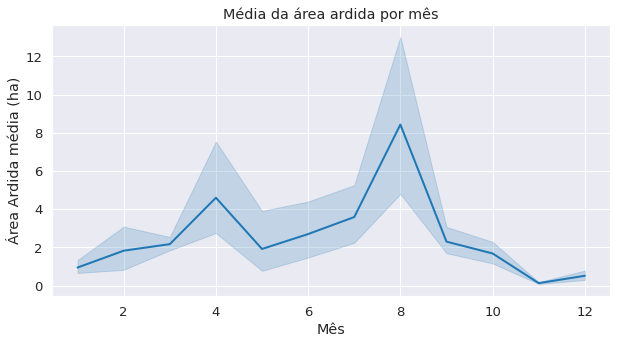

In [97]:
plt.figure(figsize = (10,5))
sns.lineplot(data=df2, y ='AA_Total (pov+mato+agric) (ha)', x='MesAlerta')
plt.title('Média da área ardida por mês')
plt.xlabel('Mês')
plt.ylabel('Área Ardida média (ha)')

Neste gráfico, a linha azul escura representa a média de área total queimada, enquanto que a sompra azulada corresponde ao intervalo de confiança, para os respectivos meses.

Observa-se um pico de queimadas em agosto, e isto está de acordo com os dados pesquisados nos relatórios previamentos citados. Isto é coerente, dado que agosto é o mês com temperaturas mais altas, favorecendo tanto o início de queimadas quanto sua mantunetação, e o vento quente ajuda em sua dissipação. Oposto a isso, de novembro a janeiro se observa valores de área ardida bastante baixos.

Com o agravamento no mês de agosto da dimensão dos incêndios o tempo de resposta sofre um aumento sensível e perceptível. Isto demonstra que o tempo de resposta possui um ponto de saturação de onde o agravamento da frequência e dimensão das ocorrências impacta no tempo das equipes para se locomoverem até os pontos de incêndios notificados

#####Área Ardida de Povoamento:

Text(0, 0.5, 'Área Ardida de Povoamento (ha)')

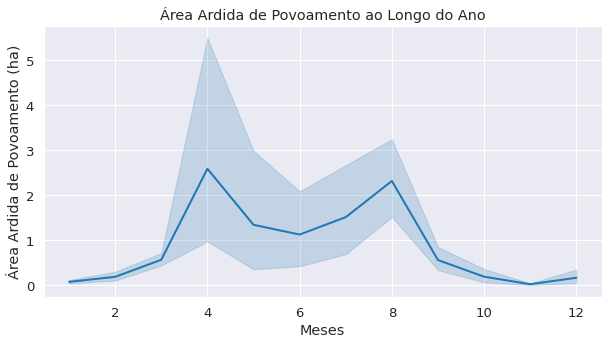

In [98]:
plt.figure(figsize = (10,5))
sns.lineplot(data=df2, y ='AA_Povoamento (ha)', x='MesAlerta')
plt.title('Área Ardida de Povoamento ao Longo do Ano')
plt.xlabel('Meses')
plt.ylabel('Área Ardida de Povoamento (ha)')

Aqui, abservam-se dois picos de área queimada: um em Abril e o outro em Agosto

#####Área Ardida de Mato:

Text(0, 0.5, 'Área Ardida de Mato (ha)')

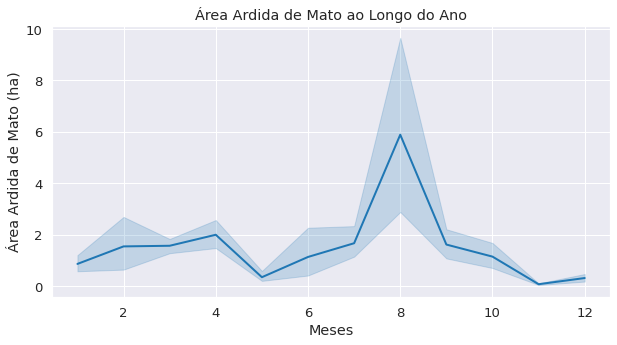

In [99]:
plt.figure(figsize = (10,5))
sns.lineplot(data=df2, y ='AA_Mato (ha)', x='MesAlerta')
plt.title('Área Ardida de Mato ao Longo do Ano')
plt.xlabel('Meses')
plt.ylabel('Área Ardida de Mato (ha)')

Este gráfico acompanha a mesma lógica do primeiro (que trata da área total)

#####Área Ardida Agricola:

Text(0, 0.5, 'Área Ardida Agrícola (ha)')

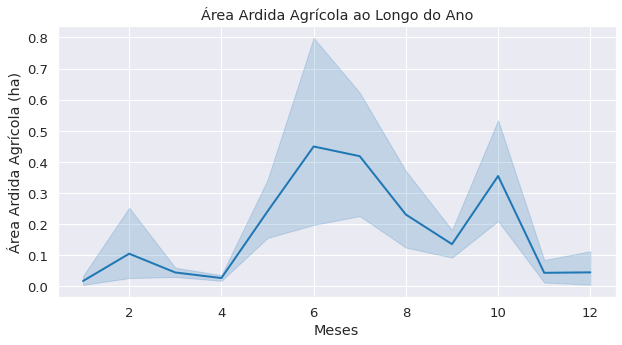

In [100]:
plt.figure(figsize = (10,5))
sns.lineplot(data=df2, y ='AA_Agricola (ha)', x='MesAlerta')
plt.title('Área Ardida Agrícola ao Longo do Ano')
plt.xlabel('Meses')
plt.ylabel('Área Ardida Agrícola (ha)')

#####Área Ardida Florestal:

Text(0, 0.5, 'Área Ardida Florestal (ha)')

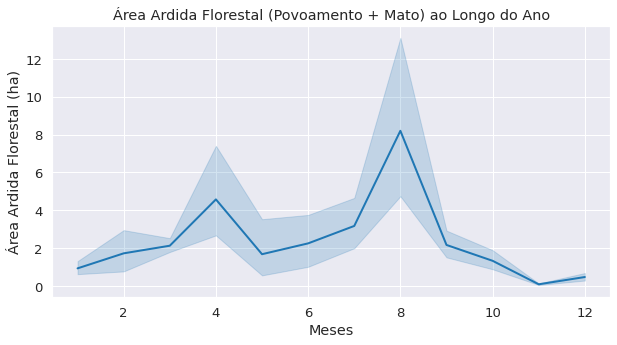

In [101]:
plt.figure(figsize = (10,5))
sns.lineplot(data=df2, y ='AA_EspacosFlorestais (pov+mato)(ha)', x='MesAlerta')
plt.title('Área Ardida Florestal (Povoamento + Mato) ao Longo do Ano')
plt.xlabel('Meses')
plt.ylabel('Área Ardida Florestal (ha)')

A área agrícola ardida possui um perfil de queimadas ao longo do ano diferente das demais (quase inverso), como a área de poamento ardida ou a área de mato ardida, por exemplo.

Para a área de mato ardida a primeira alta ocorre em abril e a segunda - e bastante mais acentuada - alta em agosto (mês mais quente). Para a área de povoamento ardida é semelhante, porém, a temperatura ambiente parece ter menos influência, o que faz sentido, e dessa forma as altas dos meses de abril e agosto são parecidas.

Já para a área agrícola ardida as altas são observadas nos meses de junho, julho e outubro, indicando uma influência da temperatura ambiente mas é provável que haja algum outro fator forte determinante.

#####Área Ardida por Tipos de Causa:

Text(0.5, 0, 'Mês')

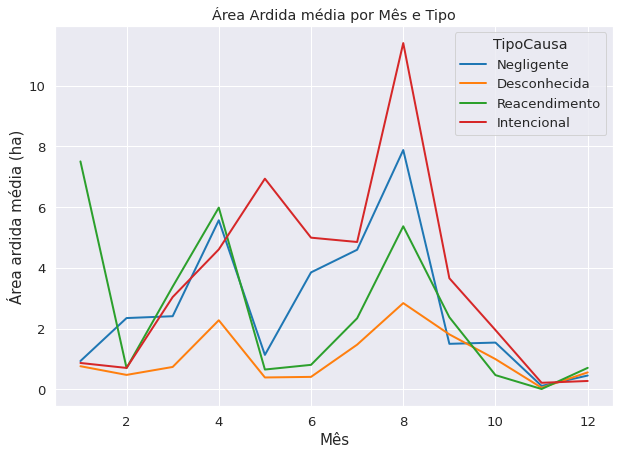

In [102]:
plt.figure(figsize=(10,7))
plt.title("Área Ardida média por Mês e Tipo")
ax = sns.lineplot(x=df2['DataAlerta'].dt.month, y=df2['AA_EspacosFlorestais (pov+mato)(ha)'], data=df2, #df2[df2['AA_EspacosFlorestais (pov+mato)(ha)']<400]['AA_EspacosFlorestais (pov+mato)(ha)']
               hue=df2[df2['TipoCausa'] != 'Natural']['TipoCausa'], err_style=None) #strftime('%b') ##, sort=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_ylabel('Área ardida média (ha)', fontsize=15)
ax.set_xlabel('Mês', fontsize=15)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Meses')

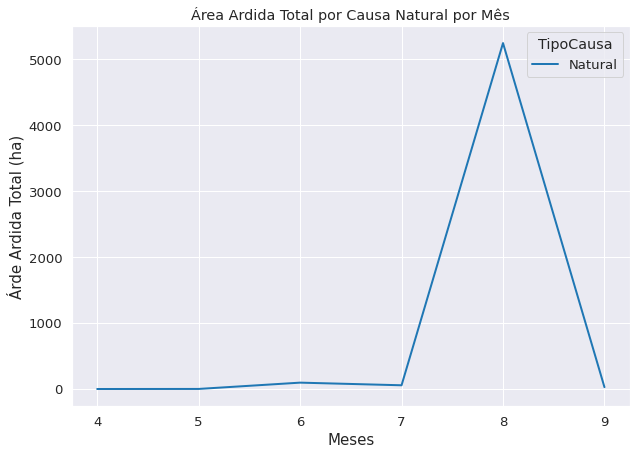

In [103]:
plt.figure(figsize=(10,7))
plt.title("Área Ardida Total por Causa Natural por Mês")
ax = sns.lineplot(x=df2['DataAlerta'].dt.month, y=df2['AA_EspacosFlorestais (pov+mato)(ha)'], data=df2, #df2[df2['AA_EspacosFlorestais (pov+mato)(ha)']<400]['AA_EspacosFlorestais (pov+mato)(ha)']
               hue=df2[df2['TipoCausa'] == 'Natural']['TipoCausa'], err_style=None, estimator = sum) #strftime('%b') ##, sort=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_ylabel('Árde Ardida Total (ha)', fontsize=15)
ax.set_xlabel('Meses', fontsize=15)

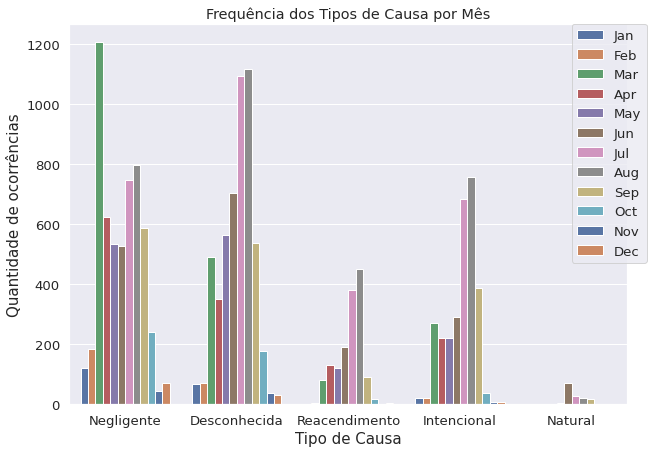

In [104]:
plt.figure(figsize=(10,7))
plt.title("Frequência dos Tipos de Causa por Mês")
ax = sns.countplot(x=df2['TipoCausa'], data=df2, hue='MesAlerta-str', palette='deep',
                   hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) 
ax.set_ylabel('Quantidade de ocorrências', fontsize=15)
ax.set_xlabel('Tipo de Causa', fontsize=15)
plt.legend(bbox_to_anchor=(.9, 1), loc=2, borderaxespad=0.)

Observa-se que em março ocorreu um pico de indêncidos por negligência, que foge a tendência geral do gráfico e para entender melhor este comportamento seria necessário avaliar as ocorrências por tipo de causa negligente, dados que não possuimos.

Os tipos de causa "negligente" e "desconhecido" são os com mais ocorrêcias em todos os meses. Desconsiderando-se o  pico de indêncidos por negligência de março todos os tipos de causa se aproximam de uma gaussiana com máximo em agosto (acompanhando a tendência de temperatura ambiente).

####Área Ardida *vs* Tempo de Resposta

Estes gráficos serão fundamental para responder a primeira pergunta do trabalho. A partir dele conseguiremos responder se há alguma relação entre área ardida e tempo de resposta.

#####Escala Normal:

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(-1.0729999999999933, 0.5, 'Área Ardida Total (ha)')

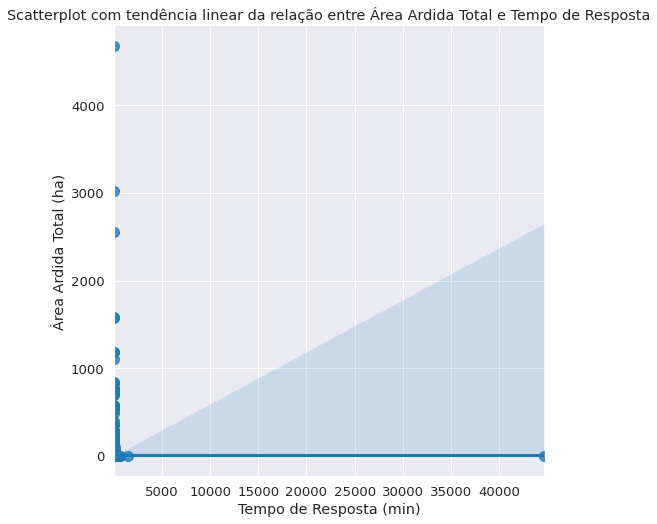

In [105]:
sns.lmplot(x='TempoResposta_Minutos', y='AA_Total (pov+mato+agric) (ha)', data=df2, palette='Blues_d', aspect=1, size=7, scatter_kws={"s": 100})
plt.title('Scatterplot com tendência linear da relação entre Área Ardida Total e Tempo de Resposta')
plt.xlabel('Tempo de Resposta (min)')
plt.ylabel('Área Ardida Total (ha)')


A reta de regressão linear é desviada devido a presença de um outliers, dando resltando em uma tendência linear irreal.

Text(0, 0.5, 'Área Ardida Total (ha)')

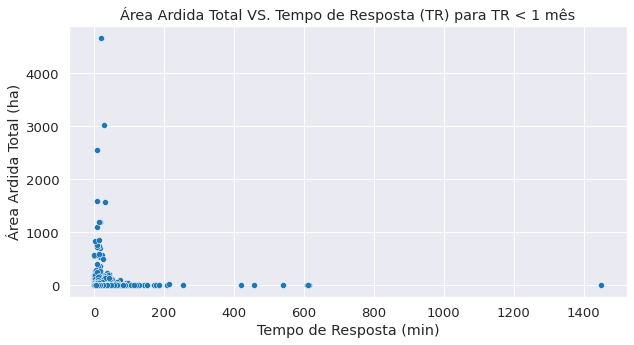

In [106]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df2, x=df2[df2['TempoResposta_Minutos']<44645]['TempoResposta_Minutos'], y='AA_Total (pov+mato+agric) (ha)')
plt.title('Área Ardida Total VS. Tempo de Resposta (TR) para TR < 1 mês')
plt.xlabel('Tempo de Resposta (min)')
plt.ylabel('Área Ardida Total (ha)')

Text(0, 0.5, 'Área Ardida Total (ha)')

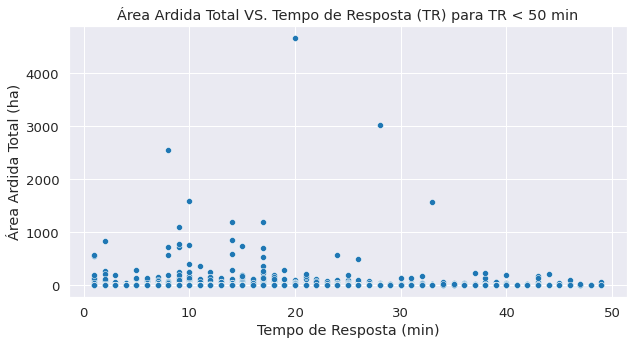

In [107]:
plt.figure(figsize = (10,5))
sns.scatterplot(data=df2, x=df2[df2['TempoResposta_Minutos']<50]['TempoResposta_Minutos'], y='AA_Total (pov+mato+agric) (ha)')
plt.title('Área Ardida Total VS. Tempo de Resposta (TR) para TR < 50 min')
plt.xlabel('Tempo de Resposta (min)')
plt.ylabel('Área Ardida Total (ha)')

Foi feita uma filtragem para Tempo de Resposta > 50 min para que fosse possível visualizar os pontos com mais detalhe.

Com este gráfico verifica-se que as observações ficam concentradas abaixo de 1000 ha.

#####Escala Logarítmica:

In [108]:
log_area = df2[df2['AA_Total (pov+mato+agric) (ha)']>=1e-10]['AA_Total (pov+mato+agric) (ha)']
df2['log_area'] = np.log(log_area)
df2['log_resposta'] = np.log(df2['TempoResposta_Minutos'])

### Analisando a distribuição da variável principal: Área Ardida Total

No handles with labels found to put in legend.


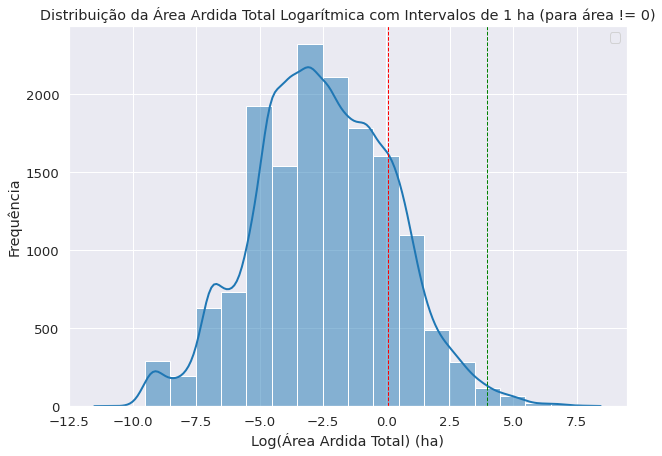

In [109]:
plt.figure(figsize=(10, 7))
plt.title('Distribuição da Área Ardida Total Logarítmica com Intervalos de 1 ha (para área != 0)')
plt.xlabel('Log(Área Ardida Total) (ha)')
plt.ylabel('Frequência')
sns.histplot(np.log(log_area), binwidth=1, kde=True)
plt.axvline(log_area.median(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(log_area.mean(), color='green', linestyle='dashed', linewidth=1)
plt.legend()

linha vertical tracejada vermelha: mediana -> Área Ardida Total ~ 1 ha

linha vertical tracejada verde: média

Para bandas de 1 ha, observa-se uma curva unimodal com pico no intervalo -3.5 < Log(área) <= -2.5, equivalente a 3.2e-4 < área <= 3.2e-3 [ha]

As medidas de tendência central(média e mediana) estão deslocadas devido ao fato de o eixo estar em escala logarítmica

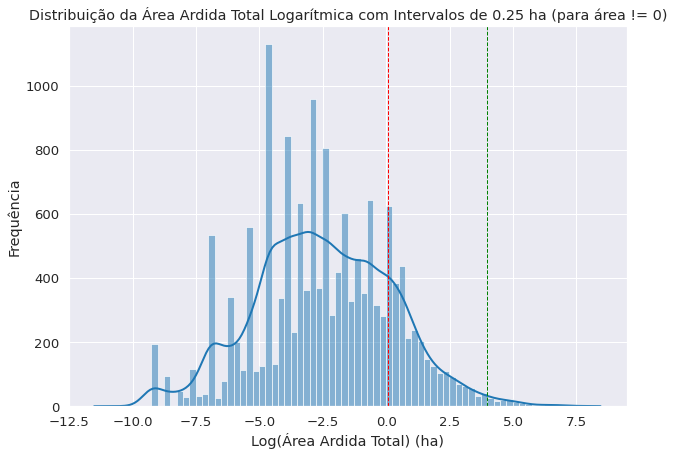

In [110]:
plt.figure(figsize=(10, 7))
plt.title('Distribuição da Área Ardida Total Logarítmica com Intervalos de 0.25 ha (para área != 0)')
plt.xlabel('Log(Área Ardida Total) (ha)')
plt.ylabel('Frequência')
sns.histplot(np.log(log_area), binwidth=0.25, kde=True)
plt.axvline(log_area.median(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(log_area.mean(), color='green', linestyle='dashed', linewidth=1)

Para bandas de 0.25 ha, observa-se uma distribuição multimodal, com máximos locais a cada 0.75 ha para a primeira metade dos objetos (mediana) e para valores superiores à mediana verifica-se um descrescimento uniforme. Pico global está no intervalo -4.75 < Log(área) <= -4.5, equivalente a 1.8e-5 < área <= 3.2e-5 [ha]

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Scatterplot com tendência linear da relação entre Log(Área Ardida Total) e Log(Tempo de Resposta)')

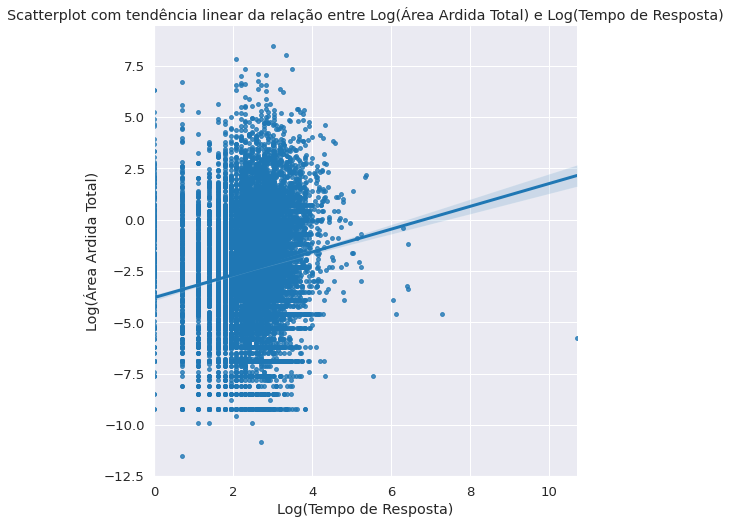

In [111]:
sns.lmplot(x='log_resposta', y='log_area', data=df2, palette='Blues_d', aspect=1, size=7, scatter_kws={"s": 15})
plt.xlabel('Log(Tempo de Resposta)')
plt.ylabel('Log(Área Ardida Total)')
plt.title('Scatterplot com tendência linear da relação entre Log(Área Ardida Total) e Log(Tempo de Resposta)')

Por esses gráficos não se observa relação entre a área ardida e o tempo entre o alerta e o início da intervenção. A reta de regressão linear não faz sentido e nãoo expressa qualquer relação, já que se observa uma nuvem dispersa de pontos sem tendência alinhada à reta. Parte da distorção de sua inclinação se dá pela presença de pontos dispersos (possíveis outliers remanescentes).

Os gráficos que plotam **Área Ardida** *vs* **Tempo de Intervenção** nos levam a acreditar que não há uma relação linear entre essas duas variáveis. Portanto, é possível que as carácteríticas de cada incêndio contribuam de forma mais relevante para a área ardida. Nesse sentido, em um incêndio de vegetação densa que se inicia a partir de diversos focos espera-se uma área ardida alta, mesmo que o tempo de resposta seja muito rápido. Por outro lado, em regiões com baixa densidade de vegetação e um foco de incendio concentrado, mesmo com um elevado tempo de resposta, espera-se um valor reduzido de área ardida. 

####Mapa de Correlações

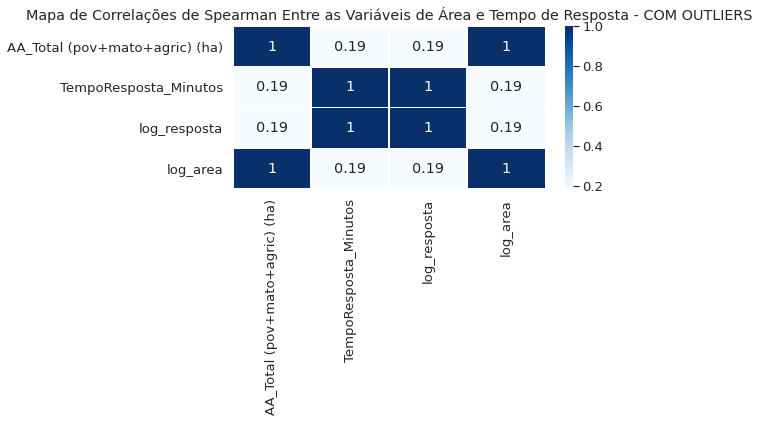

In [112]:
plt.figure(figsize=(7,3))
plt.title('Mapa de Correlações de Spearman Entre as Variáveis de Área e Tempo de Resposta - COM OUTLIERS')
sns.heatmap(df2[['AA_Total (pov+mato+agric) (ha)', 'TempoResposta_Minutos', 'log_resposta', 'log_area']].corr(method='spearman'),
            cmap='Blues',  linewidth=0.5, annot=True)

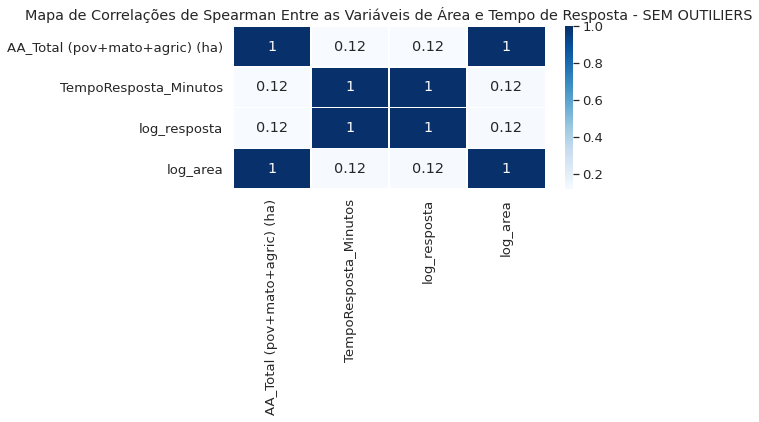

In [113]:
log_area_3 = df3[df3['AA_Total (pov+mato+agric) (ha)']>=1e-10]['AA_Total (pov+mato+agric) (ha)']
df3['log_area'] = np.log(log_area_3)
df3['log_resposta'] = np.log(df3['TempoResposta_Minutos'])

plt.figure(figsize=(7,3))
plt.title('Mapa de Correlações de Spearman Entre as Variáveis de Área e Tempo de Resposta - SEM OUTILIERS')
sns.heatmap(df3[['AA_Total (pov+mato+agric) (ha)', 'TempoResposta_Minutos', 'log_resposta', 'log_area']].corr(method='spearman'),
            cmap='Blues',  linewidth=0.5, annot=True)

A correlação de Spearman é uma medida não paramétrica de correlação de classificação (dependência estatística entre as classificações de duas variáveis). Ele avalia o quão bem a relação entre duas variáveis pode ser descrita usando uma função monotônica (não necessariamente linear). Por outro lado, a correlação de Pearson é uma estatística que mede a correlação linear entre duas variáveis.

De fato, observa-se que a correlação de Spearman entre a Área Ardida e o Tempo de Resposta é bastante baixa (<0.20), o que justifica o comportamento não padronizado do gráfico plotado anteriormente. Utilizando-se a correlação de Pearson os valores ficaram próximos de 0, ou seja, a correlação é muito fraca, mas a correlação linear, especialmente, é praticamente nula.

